# Causal reasoning in dynamical systems

## Outline

- [Setup](#setup)

- [Overview: Causal Inference in Continuous Time Dynamical Systems](#overview:-causal-inference-in-continuous-time-dynamical-systems)
    - [Task: Modeling Causal Interventions in Continuous Time Systems](#task:-modeling-causal-interventions-in-continuous-time-systems)
    - [Challenge: Representational Complexities of ODEs in Causal Inference](#challenge:-representational-complexities-of-odes-in-causal-inference)
    - [Assumptions: Deterministic Dynamics and No Latent Confounders](#assumptions:-deterministic-dynamics-and-no-latent-confounders)
    - [Intuition: Understanding Interventions in Dynamical Systems](#intuition:-understanding-interventions-in-dynamical-systems)

- [Example: Assessing Intervention Strategies in an Epidemic Model](#example:-assessing-intervention-strategies-in-an-epidemic-model)
    - [Variables](#variables)
    - [Motivation](#motivation)
    - [Source](#source)

- [Causal Probabilistic Program](#causal-probabilistic-program)
    - [Model Description](#model-description)
    - [Observation Model](#observation-model)
    - [Generating Synthetic Disease Data using simulate](#generating-synthetic-disease-data-using-simulate)
    - [Informal Prior Predictive Check: Visualizing Samples](#informal-prior-predictive-check---visualizing-samples)

- [Probabilistic Inference over Dynamical System Parameters](#probabilistic-inference-over-dynamical-system-parameters)
    - [Informal Posterior Predictive Check: Visualizing Samples](#informal-posterior-predictive-check---visualizing-samples)

- [Exploring Interventions](#exploring-interventions)
    - [Modeling a Deterministic Intervention](#modeling-a-deterministic-intervention)
    - [Modeling an Uncertain Intervention](#modeling-an-uncertain-intervention)
    - [Modeling a State-Dependent Intervention](#modeling-a-state-dependent-intervention)
    - [Modeling a State-Dependent Intervention with Uncertainty](#modeling-a-state-dependent-intervention-with-uncertainty)

- [References](#references)


## Setup

Here, we install the necessary Pytorch, Pyro, and ChiRho dependencies for this example.

In [4]:
%reload_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings('ignore')

import os
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoMultivariateNormal

from chirho.dynamical.handlers import (
    DynamicIntervention,
    LogTrajectory,
    StaticBatchObservation,
    StaticIntervention,
)
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import Dynamics, State, simulate
from chirho.observational.handlers import condition

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

smoke_test = ('CI' in os.environ)
num_steps = 10 if smoke_test else 1000
num_samples = 10 if smoke_test else 200

In [21]:
class SIRDynamics(pyro.nn.PyroModule):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def forward(self, X: State[torch.Tensor]):
        dX = dict()
        dX["S"] = -self.beta * X["S"] * X["I"]
        dX["I"] = self.beta * X["S"] * X["I"] - self.gamma * X["I"]
        dX["R"] = self.gamma * X["I"]
        return dX
    
def sir_observation_model(X: State[torch.Tensor]) -> None:
    # We don't observe the number of susceptible individuals directly.
    
    # Note: Here we set the event_dim to 1 if the last dimension of X["I"] is > 1, as the sir_observation_model
    # can be used for both single and multi-dimensional observations.
    event_dim = 1 if X["I"].shape and X["I"].shape[-1] > 1 else 0
    pyro.sample("I_obs", dist.Poisson(X["I"]).to_event(event_dim))  # noisy number of infected actually observed
    pyro.sample("R_obs", dist.Poisson(X["R"]).to_event(event_dim))  # noisy number of recovered actually observed



In [124]:
n_stratum = 3

# Assume there is initially a population of 99 million people that are susceptible, 1 million infected, and 0 recovered
init_state = dict(S=torch.ones(n_stratum) * 99, I=torch.ones(n_stratum), R=torch.zeros(n_stratum))
start_time = torch.tensor(0.0)
end_time = torch.tensor(3.0)
step_size = torch.tensor(0.1)
logging_times = torch.arange(start_time, end_time, step_size)


# We now simulate from the SIR model
beta_true = torch.tensor([0.03, 0.04, 0.07])
gamma_true = torch.tensor([0.5, 0.3, 0.4])
sir_true = SIRDynamics(beta_true, gamma_true)
with TorchDiffEq(), LogTrajectory(logging_times) as lt:
    simulate(sir_true, init_state, start_time, end_time)

sir_true_traj = lt.trajectory

obs_start_time = torch.tensor(0.5) # Measurements start 0.5 month into the pandemic
obs_sample_rate = torch.tensor(1/30) # Take measurements one per day
obs_end_time = torch.tensor(1.0) # Measurements end after 1st month

obs_logging_times = torch.arange(obs_start_time, obs_end_time, obs_sample_rate)
N_obs = obs_logging_times.shape[0]
with TorchDiffEq(), LogTrajectory(obs_logging_times) as lt_obs:
    simulate(sir_true, init_state, start_time, obs_end_time)

sir_obs_traj = lt_obs.trajectory
with pyro.poutine.trace() as tr:
    sir_observation_model(sir_obs_traj)

sir_data = dict(**{k:tr.trace.nodes[k]["value"][0, :] for k in ["I_obs", "R_obs"]})

Text(0.5, 0, 'Time (Months)')

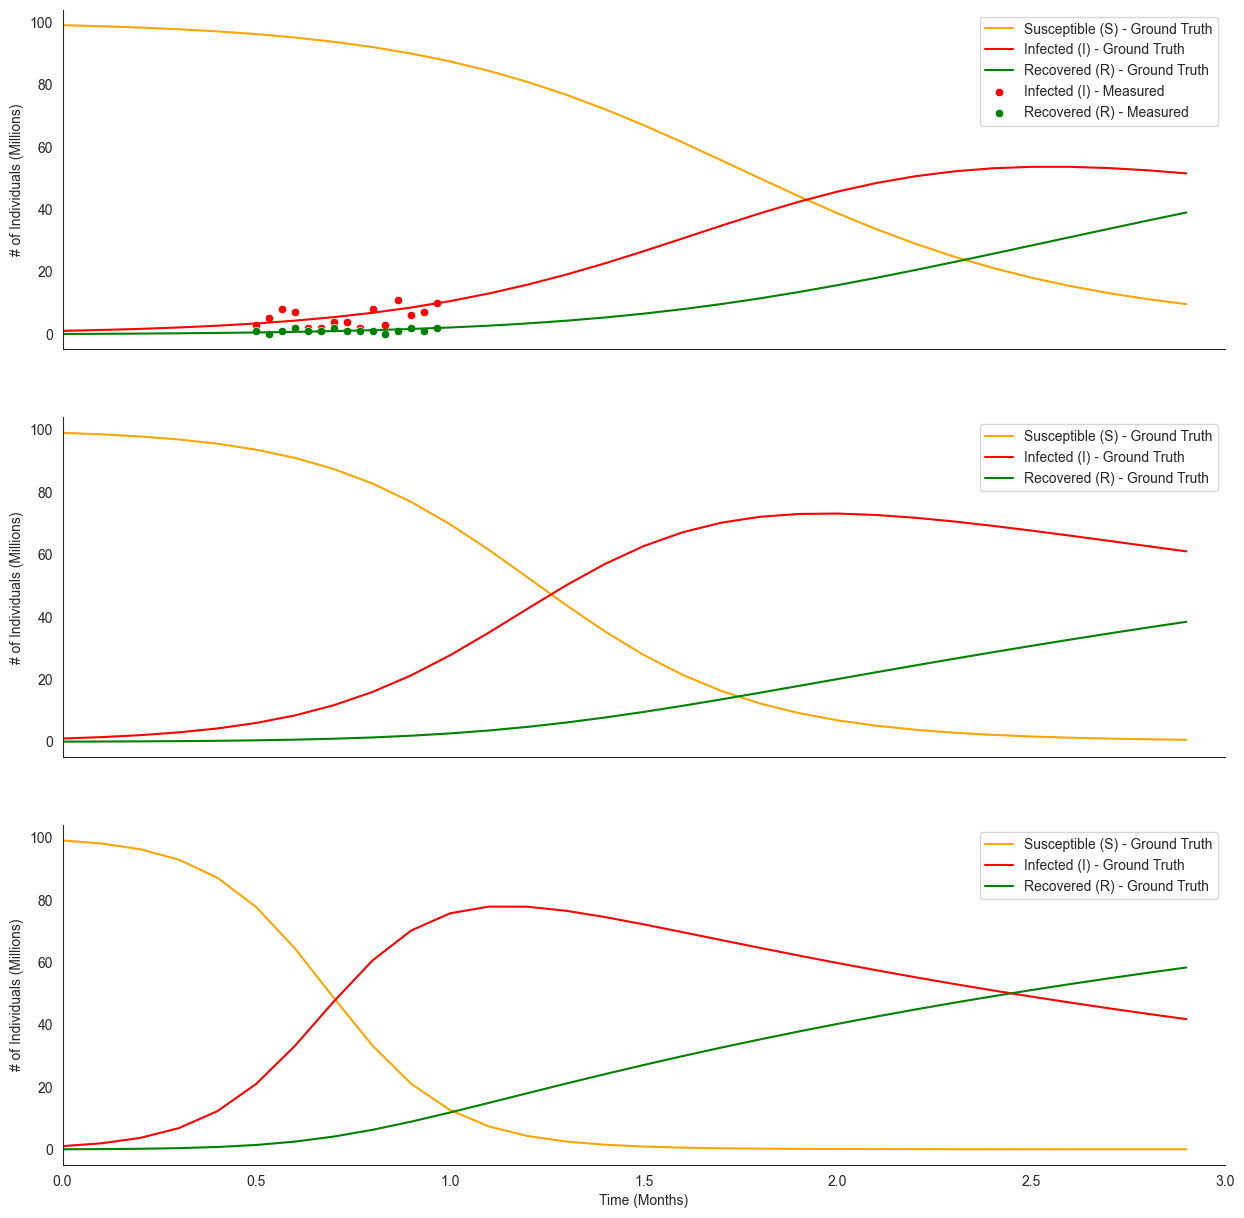

In [125]:

fig, axes = plt.subplots(n_stratum, 1, figsize=(15, 15), sharex=True)
for i in range(n_stratum):
    ax = axes[i]
    sns.lineplot(
        x=logging_times, y=sir_true_traj["S"][i, :], label="Susceptible (S) - Ground Truth", color="orange", ax=ax
    )
    sns.lineplot(x=logging_times, y=sir_true_traj["I"][i, :], label="Infected (I) - Ground Truth", color="red", ax=ax)
    sns.lineplot(x=logging_times, y=sir_true_traj["R"][i, :], label="Recovered (R) - Ground Truth", color="green", ax=ax)
    if i == 0:
        sns.scatterplot(x=obs_logging_times, y=sir_data["I_obs"], label="Infected (I) - Measured", color="red", ax=ax)
        sns.scatterplot(x=obs_logging_times, y=sir_data["R_obs"], label="Recovered (R) - Measured", color="green", ax=ax)
        ax.legend(loc="upper right")
    sns.despine()

    ax.set_xlim(start_time, end_time)
    ax.set_ylabel("# of Individuals (Millions)")

plt.xlabel("Time (Months)")
    
    

## Bayesian Partial Pooling with Dynamical Systems

In [126]:
from typing import Callable

def reparameterize_inverse_gamma(mean, variance):
    # alpha = mean ** 2 / variance
    # beta = mean * alpha
    alpha = 2 + mean ** 2 / variance
    beta = mean * (alpha - 1)
    return alpha, beta

def bayesian_multilevel_sir(n_stratum: int, base_model: Callable[[torch.Tensor], Dynamics[torch.Tensor]]=SIRDynamics) -> Dynamics[torch.Tensor]:
    beta_mean = pyro.sample("beta_mean", dist.Beta(1, 10))
    beta_variance = 0.01
    
    gamma_mean = pyro.sample("gamma_mean", dist.Beta(10, 10))
    gamma_variance = 0.01
    
    with pyro.plate("stratum", size=n_stratum, dim=-1):
        beta = pyro.sample("beta", dist.InverseGamma(*reparameterize_inverse_gamma(beta_mean, beta_variance)))
        gamma = pyro.sample("gamma", dist.InverseGamma(*reparameterize_inverse_gamma(gamma_mean, gamma_variance)))
    sir = base_model(beta, gamma)
    return sir

def simulated_multilevel_bayesian_sir(init_state, start_time, logging_times, base_model=SIRDynamics) -> State[torch.Tensor]:
    n_stratum = init_state["S"].shape[-1]
    assert init_state["I"].shape[-1] == init_state["R"].shape[-1] == n_stratum
    sir = bayesian_multilevel_sir(n_stratum, base_model)
    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=True) as lt:
        simulate(sir, init_state, start_time, logging_times[-1])
    return lt.trajectory

In [128]:
prior_predictive = Predictive(simulated_multilevel_bayesian_sir, num_samples=num_samples, parallel=True)
prior_samples = prior_predictive(init_state, start_time, logging_times)

In [129]:
def SIR_uncertainty_plot(time_period, state_pred, ylabel, color, ax, mean_label="Posterior Mean"):
    sns.lineplot(
        x=time_period,
        y=state_pred.mean(dim=0),
        color=color,
        label=mean_label,
        ax=ax,
    )
    # 95% Credible Interval
    ax.fill_between(
        time_period,
        torch.quantile(state_pred, 0.025, dim=0),
        torch.quantile(state_pred, 0.975, dim=0),
        alpha=0.2,
        color=color,
        label="95% Credible Interval",
    )

    ax.set_xlabel("Time (Months)")
    ax.set_ylabel(ylabel)


def SIR_data_plot(time_period, data, data_label, ax):
    sns.lineplot(
        x=time_period, y=data, color="black", ax=ax, linestyle="--", label=data_label
    )


def SIR_test_plot(test_start_time, test_end_time, ax):
    ax.axvline(
        test_start_time, color="black", linestyle=":", label="Measurement Period"
    )
    ax.axvline(
        test_end_time, color="black", linestyle=":"
    )


def SIR_plot(
    time_period,
    state_pred,
    data,
    ylabel,
    color,
    data_label,
    ax,
    legend=False,
    test_plot=True,
    test_start_time=obs_start_time,
    test_end_time=obs_end_time,
    mean_label="Posterior Mean",
):
    SIR_uncertainty_plot(time_period, state_pred, ylabel, color, ax, mean_label=mean_label)
    SIR_data_plot(time_period, data, data_label, ax)
    if test_plot:
        SIR_test_plot(test_start_time, test_end_time, ax)
    if legend:
        ax.legend()
    else:
        ax.legend().remove()
    sns.despine()

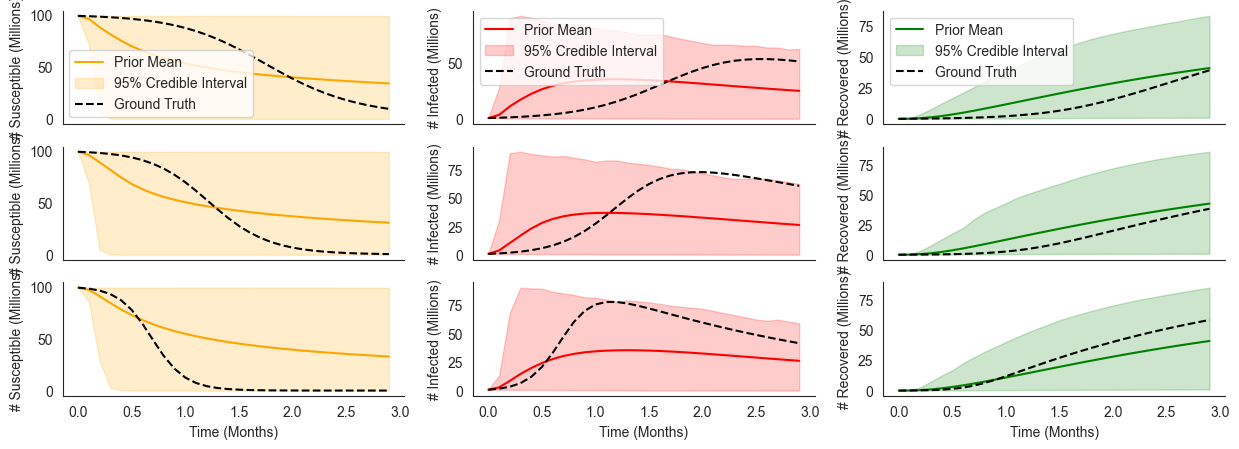

In [131]:

fig, ax = plt.subplots(n_stratum, 3, figsize=(15, 5), sharex=True)

for i in range(n_stratum):

    if i == 0:
        legend = True
    else:
        legend = False
    SIR_plot(
        logging_times,
        prior_samples["S"][..., 0, i, :],
        sir_true_traj["S"][i, :], 
        "# Susceptible (Millions)",
        "orange",
        "Ground Truth",
        ax[i, 0],
        legend=legend,
        test_plot=False,
        mean_label="Prior Mean",
    )

    SIR_plot(
        logging_times,
        prior_samples["I"][..., 0, i, :],
        sir_true_traj["I"][i, :],
        "# Infected (Millions)",
        "red",
        "Ground Truth",
        ax[i, 1],
        legend=legend,
        test_plot=False,
        mean_label="Prior Mean",
    )

    SIR_plot(
        logging_times,
        prior_samples["R"][..., 0, i, :],
        sir_true_traj["R"][i, :],
        "# Recovered (Millions)",
        "green",
        "Ground Truth",
        ax[i, 2],
        legend=legend,
        test_plot=False,
        mean_label="Prior Mean",
    )

Here, we can see that without any data our prior has induced extremely broad uncertainty over resulting disease dynamics.

## Probabilistic Inference over Dynamical System Parameters

One of the major benefits of writing our dynamical systems model in Pyro and ChiRho is that we can leverage Pyro's support for (partially) automated probabilistic inference. In this section we'll (i) condition on observational data using the `StaticBatchObservation` effect handler and (ii) optimize a variational approximation to the posterior using Pyro's SVI utilities.

In [9]:
def conditioned_sir(obs_times, data, init_state, start_time, base_model=SIRDynamics) -> None:
    sir = bayesian_sir(base_model)
    obs = condition(data=data)(sir_observation_model)
    with TorchDiffEq(), StaticBatchObservation(obs_times, observation=obs):
        simulate(sir, init_state, start_time, obs_times[-1])

# Define a helper function to run SVI. (Generally, Pyro users like to have more control over the training process!)
def run_svi_inference(model, num_steps=num_steps, verbose=True, lr=.03, vi_family=AutoMultivariateNormal, guide=None, **model_kwargs):
    if guide is None:
        guide = vi_family(model)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, num_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        adam.step()
        if (step % 100 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))
    return guide

In [10]:
# Run inference to approximate the posterior distribution of the SIR model parameters
sir_guide = run_svi_inference(
    conditioned_sir,
    num_steps=num_steps,
    obs_times=obs_logging_times,
    data=sir_data,
    init_state=init_state,
    start_time=start_time,
)

[iteration 0001] loss: 1200.2018
[iteration 0100] loss: 1005.9518
[iteration 0200] loss: 92.1288
[iteration 0300] loss: 57.2114
[iteration 0400] loss: 56.9112
[iteration 0500] loss: 65.3044
[iteration 0600] loss: 65.4536
[iteration 0700] loss: 60.4688
[iteration 0800] loss: 59.6470
[iteration 0900] loss: 57.3681
[iteration 1000] loss: 57.6638


### Informal Posterior Predictive Check - Visualizing Samples

Now that we've approximated the posterior distribution over parameters, let's see how the posterior samples compare to the ground truth parameters and disease trajectories.

In [11]:
# Generate samples from the posterior predictive distribution
sir_predictive = Predictive(simulated_bayesian_sir, guide=sir_guide, num_samples=num_samples)
sir_posterior_samples = sir_predictive(init_state, start_time, logging_times)

Text(0.5, 0, 'Gamma')

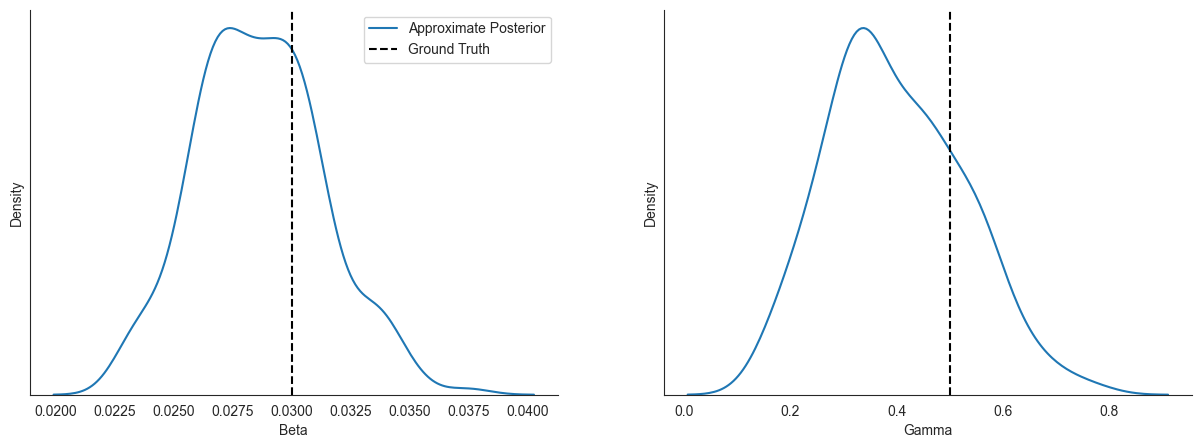

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(sir_posterior_samples["beta"], label="Approximate Posterior", ax=ax[0])
ax[0].axvline(beta_true, color="black", label="Ground Truth", linestyle="--")
sns.despine()
ax[0].set_yticks([])
ax[0].legend(loc="upper right")
ax[0].set_xlabel("Beta")

sns.kdeplot(sir_posterior_samples["gamma"], ax=ax[1])
plt.axvline(gamma_true, color="black", linestyle="--")
sns.despine()
ax[1].set_yticks([])
ax[1].set_xlabel("Gamma")

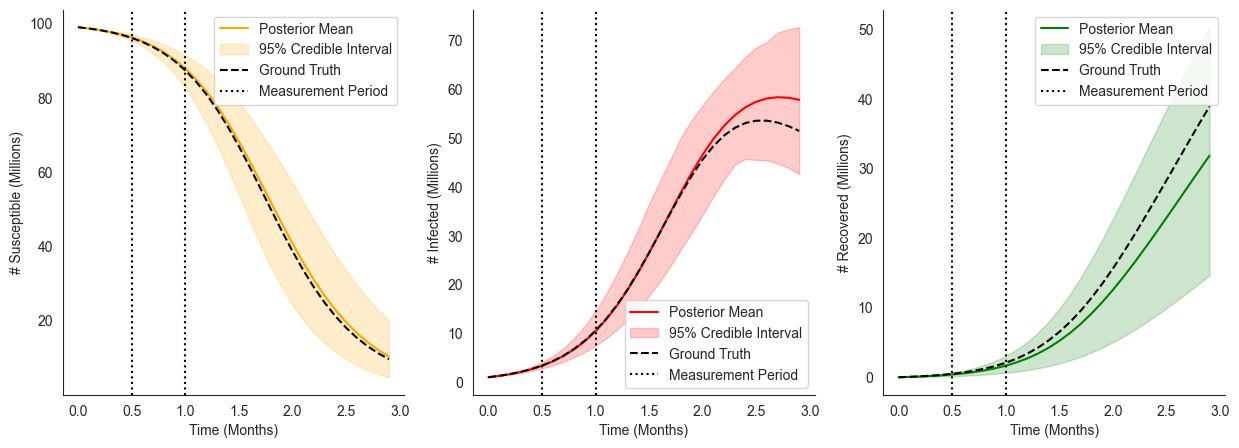

In [13]:
# Plot predicted values for S, I, and R with 95% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    logging_times,
    sir_posterior_samples["S"],
    sir_true_traj["S"],
    "# Susceptible (Millions)",
    "orange",
    "Ground Truth",
    ax[0],
    legend=True,
)
SIR_plot(
    logging_times,
    sir_posterior_samples["I"],
    sir_true_traj["I"],
    "# Infected (Millions)",
    "red",
    "Ground Truth",
    ax[1],
    legend=True,
)
SIR_plot(
    logging_times,
    sir_posterior_samples["R"],
    sir_true_traj["R"],
    "# Recovered (Millions)",
    "green",
    "Ground Truth",
    ax[2],
    legend=True,
)

## Exploring Interventions

Suppose the government can enact different lockdown measures (of varying strength) to flatten the infection curve. Following [2], we define the stength of lockdown measure at time $t$ by $l(t) \in [0, 1]$ for $1 \leq t \leq T$. Parametrize the transmission rate $\beta_t$ as:

$$
\beta(t) = (1 - l(t)) \beta_0,
$$

where $\beta_0$ denotes the unmitigated transmission rate and larger values of $l(t)$ correspond to stronger lockdown measures. Then, the time-varying SIR model is defined as follows:

$$
\begin{split}
    dS/dt &= -\beta(t) S I \\
    dI/dt &= \beta(t) S I - \gamma I \\
    dR/dt &= \gamma I
\end{split}
$$

where $S, I, R$ denote the number of susceptible, infected, and recovered individuals at time $t$ for $1 \leq t \leq T$.

We can implement this new model compositionally using our existing SIR model implementation.

In [14]:
class SIRDynamicsLockdown(SIRDynamics):
    def __init__(self, beta0, gamma):
        super().__init__(beta0, gamma)
        self.beta0 = beta0

    def forward(self, X: State[torch.Tensor]):
        self.beta = (1 - X["l"]) * self.beta0  # time-varing beta parametrized by lockdown strength l_t
        dX = super().forward(X)
        dX["l"] = torch.zeros_like(X["l"])  # no dynamics for the lockdown strength unless intervened
        return dX


init_state_lockdown = dict(**init_state, l=torch.tensor(0.0))

### Modeling a Deterministic Intervention

Let's first look at a deterministic intervention where the transmission rate is reduced by 75% between $t=1$ and $t=2$ due to stronger lockdown measures. 

To implement this succinctly we'll use ChiRho's `StaticIntervention` handlers, which interrupt the enclosing `simulate` call to change the value of the `State` at a particular moment in time. These handlers compose freely with each other, and with the `LogTrajectory` and `TorchDiffEq` introduces earlier.

In [15]:
def intervened_sir(lockdown_start, lockdown_end, lockdown_strength, init_state, start_time, logging_times) -> State[torch.Tensor]:
    sir = bayesian_sir(SIRDynamicsLockdown)
    with LogTrajectory(logging_times, is_traced=True) as lt:
        with TorchDiffEq():
            with StaticIntervention(time=lockdown_start, intervention=dict(l=lockdown_strength)):
                with StaticIntervention(time=lockdown_end, intervention=dict(l=torch.tensor(0.0))):
                    simulate(sir, init_state, start_time, logging_times[-1])
                    
    return lt.trajectory

We see in the figure below that this lockdown measures indeed "flattens" the curve.

In [16]:
lockdown_start = torch.tensor(1.0)
lockdown_end = torch.tensor(2.0)
lockdown_strength = torch.tensor(0.75)

true_intervened_sir = pyro.condition(intervened_sir, data={"beta": beta_true, "gamma": gamma_true})
true_intervened_trajectory = true_intervened_sir(lockdown_start, lockdown_end, lockdown_strength, init_state_lockdown, start_time, logging_times)

intervened_sir_predictive = Predictive(intervened_sir, guide=sir_guide, num_samples=num_samples)
intervened_sir_posterior_samples = intervened_sir_predictive(lockdown_start, lockdown_end, lockdown_strength, init_state_lockdown, start_time, logging_times)

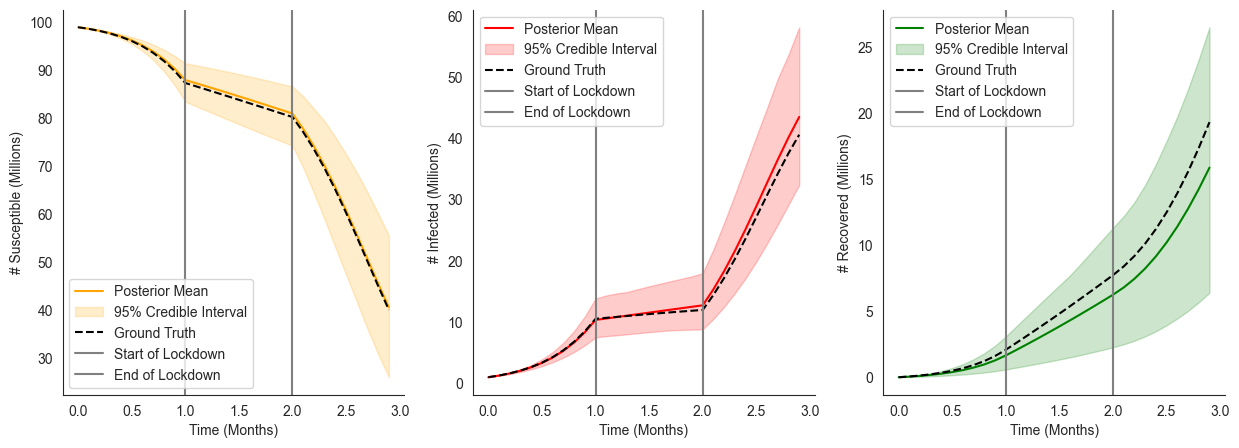

In [17]:
# Plot predicted values for S, I, and R with 95% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    logging_times,
    intervened_sir_posterior_samples["S"],
    true_intervened_trajectory["S"],
    "# Susceptible (Millions)",
    "orange",
    "Ground Truth",
    ax[0],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    intervened_sir_posterior_samples["I"],
    true_intervened_trajectory["I"],
    "# Infected (Millions)",
    "red",
    "Ground Truth",
    ax[1],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    intervened_sir_posterior_samples["R"],
    true_intervened_trajectory["R"],
    "# Recovered (Millions)",
    "green",
    "Ground Truth",
    ax[2],
    legend=True,
    test_plot=False,
)

# Plot the static intervention
for a in ax:
    a.axvline(lockdown_start, color="grey", linestyle="-", label="Start of Lockdown")
    a.axvline(lockdown_end, color="grey", linestyle="-", label="End of Lockdown")
    a.legend()

### Modeling an Uncertain Intervention

In the previous example we assumed that the time the intervention was applied was entirely determined by the policymakers. However, in practice, how an intervention is implemented may depend on many external factors that out of the policymaker's control. Instead, we'd like to represent additional uncertainty over when the intervention is applied. It turns out that implementing this extension is remarkably straightforward using ChiRho, we simply call the `intervened_sir` model with `lockdown_start` and `lockdown_end` drawn from some distribution as follows:

In [18]:
lockdown_start_min = torch.tensor(0.5)
lockdown_start_max = torch.tensor(1.5)

lockdown_end_min = torch.tensor(2.0)
lockdown_end_max = torch.tensor(2.5)

def uncertain_intervened_sir(lockdown_strength, init_state, start_time, logging_times) -> State:
    lockdown_start = pyro.sample("lockdown_start", dist.Uniform(lockdown_start_min, lockdown_start_max))
    lockdown_end = pyro.sample("lockdown_end", dist.Uniform(lockdown_end_min, lockdown_end_max))
    return intervened_sir(lockdown_start, lockdown_end, lockdown_strength, init_state, start_time, logging_times)

In [19]:
uncertain_intervened_sir_predictive = Predictive(uncertain_intervened_sir, guide=sir_guide, num_samples=num_samples)
uncertain_intervened_sir_posterior_samples = uncertain_intervened_sir_predictive(lockdown_strength, init_state_lockdown, start_time, logging_times)

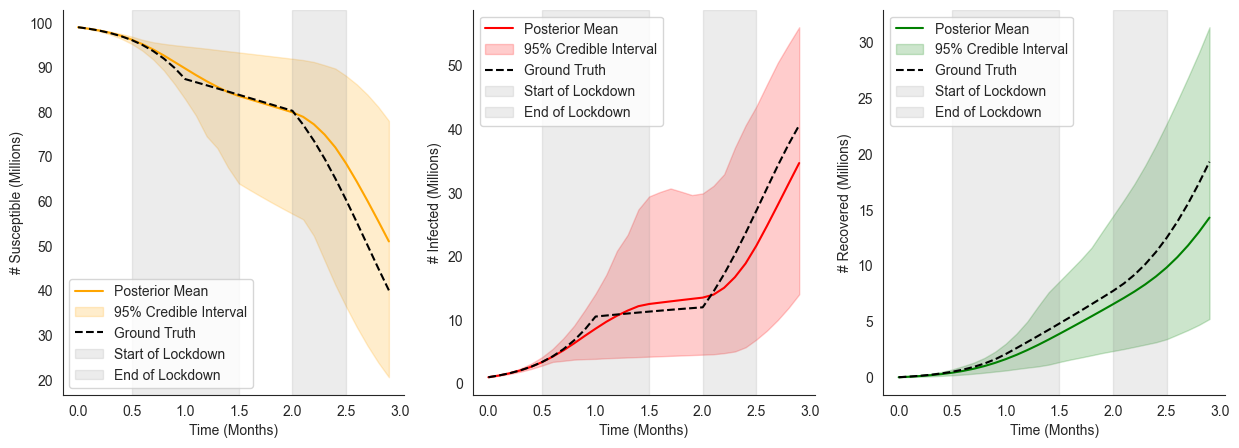

In [20]:
# Plot predicted values for S, I, and R with 95% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    logging_times,
    uncertain_intervened_sir_posterior_samples["S"],
    true_intervened_trajectory["S"],
    "# Susceptible (Millions)",
    "orange",
    "Ground Truth",
    ax[0],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    uncertain_intervened_sir_posterior_samples["I"],
    true_intervened_trajectory["I"],
    "# Infected (Millions)",
    "red",
    "Ground Truth",
    ax[1],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    uncertain_intervened_sir_posterior_samples["R"],
    true_intervened_trajectory["R"],
    "# Recovered (Millions)",
    "green",
    "Ground Truth",
    ax[2],
    legend=True,
    test_plot=False,
)

# Plot the static intervention
for a in ax:
    a.axvspan(lockdown_start_min, lockdown_start_max, color="grey", linestyle="-", label="Start of Lockdown", alpha=0.15)
    a.axvspan(lockdown_end_min, lockdown_end_max, color="grey", linestyle="-", label="End of Lockdown", alpha=0.15)
    a.legend()

### Modeling a State-Dependent Intervention

In the previous example we assumed that the intervention was applied at some (uncertain) moment in time, but was independent of the disease dynamics themselves. However, more practical interventions may be expressed as policies that dynamically respond to the dynamical system's state.

Using our running example, let's assume that the government will issue a lockdown measure that reduces the transmission rate by 90% whenever the number of infected people hits 30 million infected. The government removes this lockdown when 20% of the population is recovered. Importantly, here we don't know a priori when this event will happen, instead we need the intervention to be applied dynamically based on the results of the simulation as it is run.

To implement this we'll use ChiRho's `DynamicIntervention` handler, which takes as input an `event_fn`, describing when to apply the intervention, and an `intervention`, describing what happens when the intervention is applied.

**Note:** The `DynamicIntervention` is strictly more expressive than the `StaticIntervention` described before, as one can define an `event_fn` that only triggers when $t$ is above a specific value. However, this expressiveness comes with additional runtime costs, as the solver must now solve a root-finding problem during the simulation. Therefore, we recommend using the `StaticIntervention` when the intervention time is independent of the state, and a `DynamicIntervention` otherwise.

In [21]:
def government_lockdown_policy(target_state: State[torch.tensor]):
    # Note: The event function must be a function of positional arguments t and state as follows:
    # In this case we are only interested in the number of infected individuals, so the body of the event function
    # is simply the difference between the number of infected individuals and the target number of infected individuals.
    def event_f(t: torch.tensor, state: State[torch.tensor]):
        return state["I"] - target_state["I"]

    return event_f


def government_lift_policy(target_state: State[torch.tensor]):
    # Note: See above comment for `government_lockdown_policy`.
    def event_f(t: torch.tensor, state: State[torch.tensor]):
        return target_state["R"] - state["R"]

    return event_f


def dynamic_intervened_sir(lockdown_trigger, lockdown_lift_trigger, lockdown_strength, init_state, start_time, logging_times) -> State:
    sir = bayesian_sir(SIRDynamicsLockdown)
    with LogTrajectory(logging_times, is_traced=True) as lt:
        with TorchDiffEq():
            with DynamicIntervention(event_fn=government_lockdown_policy(lockdown_trigger), intervention=dict(l=lockdown_strength)):
                with DynamicIntervention(event_fn=government_lift_policy(lockdown_lift_trigger), intervention=dict(l=torch.tensor(0.0))):
                    simulate(sir, init_state, start_time, logging_times[-1])
    return lt.trajectory

In [22]:
lockdown_trigger = dict(I=torch.tensor(30.0))
lockdown_lift_trigger = dict(R=torch.tensor(20.0))
lockdown_strength = torch.tensor(0.9)  # reduces transmission rate by 90%

true_dynamic_intervened_sir = pyro.condition(dynamic_intervened_sir, data={"beta": beta_true, "gamma": gamma_true})
true_dynamic_intervened_trajectory = true_dynamic_intervened_sir(lockdown_trigger, lockdown_lift_trigger, lockdown_strength, init_state_lockdown, start_time, logging_times)

dynamic_intervened_sir_predictive = Predictive(dynamic_intervened_sir, guide=sir_guide, num_samples=num_samples)
dynamic_intervened_sir_posterior_samples = dynamic_intervened_sir_predictive(lockdown_trigger, lockdown_lift_trigger, lockdown_strength, init_state_lockdown, start_time, logging_times)

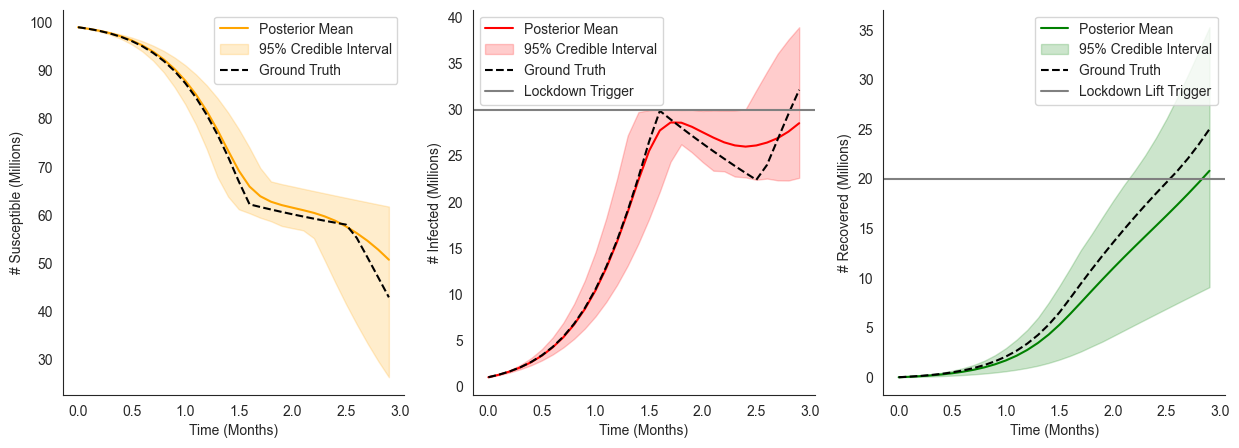

In [23]:
# Plot predicted values for S, I, and R with 95% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    logging_times,
    dynamic_intervened_sir_posterior_samples["S"],
    true_dynamic_intervened_trajectory["S"],
    "# Susceptible (Millions)",
    "orange",
    "Ground Truth",
    ax[0],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    dynamic_intervened_sir_posterior_samples["I"],
    true_dynamic_intervened_trajectory["I"],
    "# Infected (Millions)",
    "red",
    "Ground Truth",
    ax[1],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    dynamic_intervened_sir_posterior_samples["R"],
    true_dynamic_intervened_trajectory["R"],
    "# Recovered (Millions)",
    "green",
    "Ground Truth",
    ax[2],
    legend=True,
    test_plot=False,
)

# Draw horizontal line at lockdown trigger
ax[1].axhline(lockdown_trigger["I"], color="grey", linestyle="-", label="Lockdown Trigger")
ax[1].legend()
ax[2].axhline(lockdown_lift_trigger["R"], color="grey", linestyle="-", label="Lockdown Lift Trigger")
ax[2].legend()

### Modeling a State-Dependent Intervention with Uncertainty

Perhaps not surprisingly, we can also extend our `dynamic_intervened_sir` model to include uncertainty about the `lockdown_trigger` and `lockdown_lift` conditions themselves. Just as before, this can be accomplished simply by calling the `dynamic_intervened_sir` model with arguments drawn from some distribution as follows:

In [24]:
lockdown_trigger_min = torch.tensor(20.0)
lockdown_trigger_max = torch.tensor(40.0)
lockdown_lift_trigger_min = torch.tensor(10.0)
lockdown_lift_trigger_max = torch.tensor(30.0)


def uncertain_dynamic_intervened_sir(lockdown_strength, init_state, start_time, logging_times) -> State:
    lockdown_trigger = dict(I=pyro.sample("lockdown_trigger", dist.Uniform(lockdown_trigger_min, lockdown_trigger_max)))
    lockdown_lift_trigger = dict(R=pyro.sample("lockdown_lift_trigger", dist.Uniform(lockdown_lift_trigger_min, lockdown_lift_trigger_max)))
    return dynamic_intervened_sir(lockdown_trigger, lockdown_lift_trigger, lockdown_strength, init_state, start_time, logging_times)

In [25]:
uncertain_dynamic_intervened_sir_predictive = Predictive(uncertain_dynamic_intervened_sir, guide=sir_guide, num_samples=num_samples)
uncertain_dynamic_intervened_sir_posterior_samples = (uncertain_dynamic_intervened_sir_predictive(lockdown_strength, init_state_lockdown, start_time, logging_times))

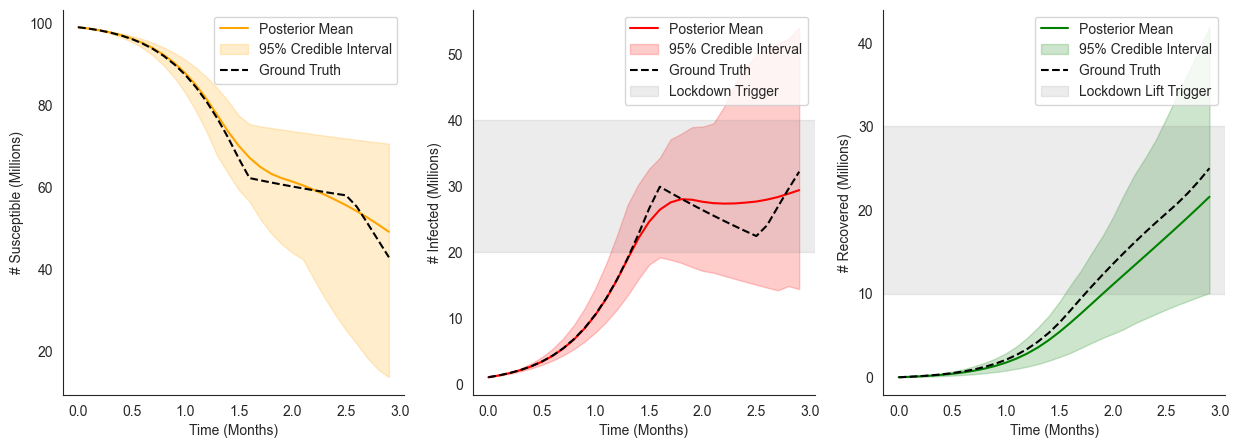

In [26]:
# Plot predicted values for S, I, and R with 95% credible intervals

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

SIR_plot(
    logging_times,
    uncertain_dynamic_intervened_sir_posterior_samples["S"],
    true_dynamic_intervened_trajectory["S"],
    "# Susceptible (Millions)",
    "orange",
    "Ground Truth",
    ax[0],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    uncertain_dynamic_intervened_sir_posterior_samples["I"],
    true_dynamic_intervened_trajectory["I"],
    "# Infected (Millions)",
    "red",
    "Ground Truth",
    ax[1],
    legend=True,
    test_plot=False,
)
SIR_plot(
    logging_times,
    uncertain_dynamic_intervened_sir_posterior_samples["R"],
    true_dynamic_intervened_trajectory["R"],
    "# Recovered (Millions)",
    "green",
    "Ground Truth",
    ax[2],
    legend=True,
    test_plot=False,
)

# Draw horizontal line at lockdown trigger
ax[1].axhspan(lockdown_trigger_min, lockdown_trigger_max, color="grey", linestyle="-", label="Lockdown Trigger", alpha=0.15)
ax[1].legend()
ax[2].axhspan(lockdown_lift_trigger_min, lockdown_lift_trigger_max, color="grey", linestyle="-", label="Lockdown Lift Trigger", alpha=0.15)
ax[2].legend()

## References
1. https://www.generable.com/post/fitting-a-basic-sir-model-in-stan
2. https://benjaminmoll.com/wp-content/uploads/2020/05/SIR_notes.pdf